# **NLP Project Title - News Article Classification**

The primary objective of this project is to build a classification model that can automatically
categorize news articles into different predefined categories. The model will be trained using
a labeled dataset of news articles and will output the most likely category (e.g., sports,
politics, or technology) for any given article.


### ***1. Importing the necessary libraries***

In [4]:
!pip install gensim

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
import gensim
from gensim import corpora
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### ***2. Importing the dataset***

In [6]:
df=pd.read_csv('/content/data_news - data_news.csv')
df.head()

,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


Need to combine the independent features (text columns-headline, short_description, keywords) into a single feature for vectorization to maximize context.

***2.1. Checking the datatype and non-null counts***: We can see many missing values in keywords column, simply dropping rows would waste the complete data in the other four columns.



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  50000 non-null  object
 4   keywords           47332 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


***2.2. Filling the missing values with an empty string (' ').***

While concatenating the text columns, an empty string won't affect the vectorization of the other columns, effectively treating those articles as having no keywords rather than deleting the entire article.

In [8]:
df['keywords']=df['keywords'].fillna(' ')

In the provided dataset links are URL data provides no value for topic classification, so removing it.

In [9]:
df.drop('links', axis=1, inplace=True)

In [10]:
df.isnull().sum()

,0
category,0
headline,0
short_description,0
keywords,0


***2.3. Checking unique values in category column***

In [11]:
df['category'].unique()

array(['WELLNESS', 'POLITICS', 'ENTERTAINMENT', 'TRAVEL',
       'STYLE & BEAUTY', 'PARENTING', 'FOOD & DRINK', 'WORLD NEWS',
       'BUSINESS', 'SPORTS'], dtype=object)

In [12]:
df['category'].value_counts()

,count
category,
WELLNESS,5000
POLITICS,5000
ENTERTAINMENT,5000
TRAVEL,5000
STYLE & BEAUTY,5000
PARENTING,5000
FOOD & DRINK,5000
WORLD NEWS,5000
BUSINESS,5000


***2.4. Visualizing the distribution of categories***

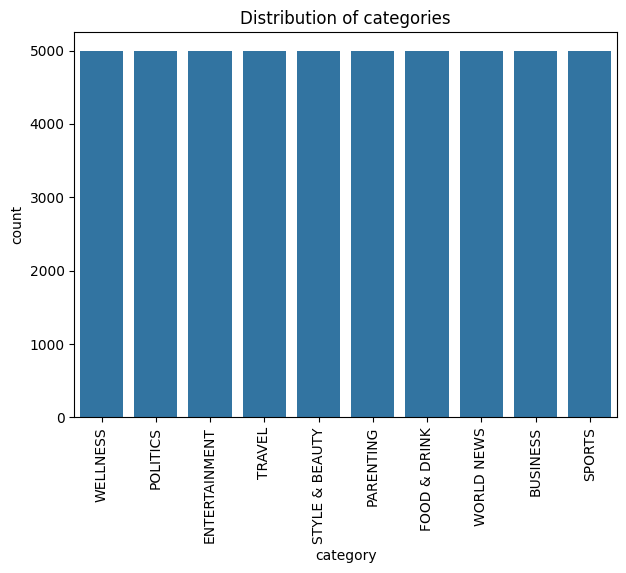

In [13]:
plt.figure(figsize=(7,5))
sns.countplot(x='category', data=df)
plt.title("Distribution of categories")
plt.xticks(rotation=90)
plt.show()

**Insights**:
* The dataset is ideal for classification tasks because it is perfectly balanced.
* can confidently use Accuracy as a primary metric, as it won't be skewed by one class dominating the predictions.

***2.5. Text length analysis and outliers detection for short_description and headline columns***

In [14]:
short_description_len=df['short_description'].str.len().describe()
headline_len=df['headline'].str.len().describe()
print(f"Text length analysis for short description: {short_description_len}")
print(f"\nText length analysis for headline: {headline_len}")

Text length analysis for short description: count    50000.000000
mean       133.350120
std         77.789444
min          1.000000
25%         82.000000
50%        122.000000
75%        167.000000
max       1392.000000
Name: short_description, dtype: float64

Text length analysis for headline: count    50000.000000
mean        56.820580
std         19.429163
min          4.000000
25%         43.000000
50%         57.000000
75%         70.000000
max        295.000000
Name: headline, dtype: float64


**Conclusion**:
* *short_description*: The data is mostly centered but has significant outliers on both ends of the scale. The single-character minimum is a data quality issue that requires removal or imputation.
* *headline*: The text length is very stable and reliable. Outlier handling is less critical for this column.

***Checking the outliers in 'short_description' column, which has length less than or equal to 5.***

In [15]:
df['description_length'] = df['short_description'].str.len()

# 2. Create a Boolean mask: length is less than or equal to 5
short_description_mask = df['description_length'] <= 5

# 3. Filter the DataFrame using the mask
short_articles = df[short_description_mask]
short_articles

,category,headline,short_description,keywords,description_length
5812,POLITICS,West Virginia Governor Brings Out Actual Bulls...,💩,jim-justice-budget-bill,1
8271,POLITICS,Here's What Would Have To Happen For Jeb Bush ...,💋,jeb-bush-warm-kiss,1
10616,ENTERTAINMENT,"This Is Where The Word 'Meme' Comes From, And ...",Huh!,origin-word-meme,4
11719,ENTERTAINMENT,Fleetwood Mac's Lindsey Buckingham And Christi...,🙌 🙌 🙌,christine-mcvie-lindsey-buckingham-duets-album,5
12580,ENTERTAINMENT,Jennifer Lawrence And Chris Pratt Are In A Lea...,OUCH!,jennifer-lawrence-chris-pratt-insults,5
12719,ENTERTAINMENT,Ariana Grande Gives Fans Singing 'One Last Tim...,OMG!,ariana-grande-surprises-fans,4
13458,ENTERTAINMENT,Teen Wolf' Actors Say Their Goodbyes To The Se...,😭 😭 😭,teen-wolf-wraps-filming-actor-goodbyes,5
15111,TRAVEL,A Friendly Reminder That There Were 0 Fatal Je...,👍👏,fatal-jet-accident-rate,2
15302,TRAVEL,You Can Order Room Service With Emojis. Peak L...,👏🏨 💥,emoji-room-service-aloft-hotels,4
20606,STYLE & BEAUTY,Kim Kardashian Accessorizes With A Kitten (PHOTO),Meow!,kim-kardashian-2012-photo,5


**Insights of Shortest Articles (Length ≤5)**:
* Clearly shows that the short descriptions are not meaningful text, but rather emojis, short exclamations, or single words designed to react to the headline.

* These short descriptions are noise for TF-IDF Vectorizer. They lack sufficient unique words or context to reliably classify the article's topic, and they would simply dilute the quality of feature set.

***2.6. Droping the rows where description_length is ≤5***

In [16]:
df_cleaned = df[df['description_length'] > 5].copy()

# 2. Verify the size of the cleaned dataset
rows_dropped = len(df) - len(df_cleaned)
print(f"Original Row Count: {len(df)}")
print(f"Cleaned Row Count: {len(df_cleaned)}")
print(f"Total Rows Dropped (Noise): {rows_dropped}")

Original Row Count: 50000
Cleaned Row Count: 49965
Total Rows Dropped (Noise): 35


### ***3. Combining the text feature***

In [17]:
df_cleaned['combined_text'] = (
    df_cleaned['headline'].astype(str) + ' ' +
    df_cleaned['short_description'].astype(str) + ' ' +
    df_cleaned['keywords'].astype(str)
)


In [18]:
df_cleaned.head()

,category,headline,short_description,keywords,description_length,combined_text
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,Resting is part of training. I've confirmed wh...,running-lessons,280,143 Miles in 35 Days: Lessons Learned Resting ...
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy,216,Talking to Yourself: Crazy or Crazy Helpful? T...
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug,120,Crenezumab: Trial Will Gauge Whether Alzheimer...
3,WELLNESS,"Oh, What a Difference She Made","If you want to be busy, keep trying to be perf...",meaningful-life,106,"Oh, What a Difference She Made If you want to ..."
4,WELLNESS,Green Superfoods,"First, the bad news: Soda bread, corned beef a...",green-superfoods,125,"Green Superfoods First, the bad news: Soda bre..."


### ***4. Preprocessing the dataset***

In [19]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [20]:
def preprocess_text(text):
    # 1. Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # 2. Remove non-letter characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # 3. Convert to lowercase
    text = text.lower()

   # 4. Tokenize words
    tokens = word_tokenize(text)

    # 5. Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # 6. Join tokens back to string
    return ' '.join(tokens)

In [21]:
df_cleaned['clean_combinedtext'] = df_cleaned['combined_text'].apply(preprocess_text)

In [22]:
df_cleaned[['combined_text', 'clean_combinedtext']].head()

,combined_text,clean_combinedtext
0,143 Miles in 35 Days: Lessons Learned Resting ...,143 mile 35 day lesson learned resting part tr...
1,Talking to Yourself: Crazy or Crazy Helpful? T...,talking crazy crazy helpful think talking tool...
2,Crenezumab: Trial Will Gauge Whether Alzheimer...,crenezumab trial gauge whether alzheimer drug ...
3,"Oh, What a Difference She Made If you want to ...",oh difference made want busy keep trying perfe...
4,"Green Superfoods First, the bad news: Soda bre...",green superfoods first bad news soda bread cor...


### ***5. Spliting the data***

In [23]:
le = LabelEncoder()
x=df_cleaned['clean_combinedtext']
y=le.fit_transform(df_cleaned['category'])

In [24]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

### ***6. Feature Engineering***

***6.1. Bag of Words(BOWs)***

Counts the frequency of each word in a document, ignoring grammar and word order.

In [25]:
bow = CountVectorizer(max_features=5000)
x_train_bow = bow.fit_transform(x_train)
x_test_bow = bow.transform(x_test)

***6.2. Word2Vec***

Creates dense vector representations of words based on their context, capturing semantic relationships (meaning) between words.

In [26]:
 # Step 1: Tokenize text
tokenized_text = [text.split() for text in df_cleaned['clean_combinedtext']]

# Step 2: Train Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_text,
    vector_size=100,   # size of word vectors
    window=5,          # context window
    min_count=2,       # ignore rare words
    workers=4,         # number of CPU cores
    sg=1               # skip-gram model (better for small data)
)

# Step 3: Create average Word2Vec vector for each review
def get_vector(tokens):
    vec = np.zeros(100)
    count = 0
    for word in tokens:
        if word in w2v_model.wv:
            vec += w2v_model.wv[word]
            count += 1
    return vec / count if count > 0 else vec

df_cleaned['text_vector'] = [get_vector(tokens) for tokens in tokenized_text]
df_cleaned['text_vector']



,text_vector
0,"[-0.2900682912341186, 0.23663616506382823, -0...."
1,"[-0.40461308548324987, 0.25116638574553163, -0..."
2,"[-0.214254266427209, 0.191281300658981, -0.348..."
3,"[-0.4376604869961739, 0.20724193826317788, -0...."
4,"[-0.3061867700399537, 0.26788618454807683, -0...."
...,...
49995,"[-0.3499337972506233, 0.2981941855472067, -0.2..."
49996,"[-0.4630777969172126, 0.23588366159483007, -0...."
49997,"[-0.20929484888911248, 0.08378194505348802, -0..."
49998,"[-0.4279660601168871, 0.18418708062381484, -0...."


***6.3. TFidf vectorizer***

Weighs word frequency by its rarity across the entire collection, emphasizing unique and important words.

In [27]:
# Choose max_features to limit the vocabulary size (e.g., 5000 or 10000)
# Use n-grams (1, 2) to capture single words and two-word phrases (e.g., "not good")

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
x_train_tfidf= vectorizer.fit_transform(x_train)
x_test_tfidf=vectorizer.transform(x_test)


***6.4. Textual (Statistical) Features***

Simple, quantifiable metrics (like word count, character count, or average word length) that capture the structural style and complexity of the text.

In [28]:
# Word count
df_cleaned['word_count'] = df_cleaned['clean_combinedtext'].apply(lambda x: len(x.split()))

# Character count
df_cleaned['char_count'] = df_cleaned['clean_combinedtext'].apply(lambda x: len(x))

# Average word length
df_cleaned['avg_word_length'] = df_cleaned['clean_combinedtext'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)

# Unique word ratio
df_cleaned['unique_word_ratio'] = df_cleaned.apply(lambda row: len(set(row['clean_combinedtext'].split())) / row['word_count']
    if row['word_count'] > 0 else 0, axis=1)

***6.5. Combining TF-IDF features with textual features***

TF-IDF features capture the textual content, while additional textual statistics describe the structure and writing style of reviews. By combining both, the model gains a richer representation of categories, leading to improved accuracy and generalization.

***Spliting the textual features to match train-test split***

In [29]:
# Textual features dataframe
text_features = df_cleaned[['word_count', 'char_count', 'avg_word_length', 'unique_word_ratio']]

# Split them according to the same indices as TF-IDF
x_train_text = text_features.loc[x_train.index]
x_test_text = text_features.loc[x_test.index]

print(f"Statistical Features Shape (Train): {x_train_text.shape}")

Statistical Features Shape (Train): (39972, 4)


In [30]:
from scipy.sparse import hstack

# Combine TF-IDF with textual features
x_train_combined = hstack([x_train_tfidf, x_train_text])
x_test_combined = hstack([x_test_tfidf, x_test_text])

print("x-train:",x_train_combined.shape)
print("x-test:",x_test_combined.shape)


x-train: (39972, 5004)
x-test: (9993, 5004)


**Using TF-IDF and Textual Features over Word2Vec**:

* **Simplicity & Speed**: TF-IDF is faster to compute, making it ideal for large datasets like IMDb.

* **Works Well with Linear Models**: Logistic Regression performs best with sparse, high-dimensional TF-IDF features.

* **Captures Word Importance**: TF-IDF highlights key sentiment words, improving classification.

* **Adds Context**: Features like word count or punctuation convey extra information (e.g., emotion) that Word2Vec ignores.

**Cons of Word2Vec**:

* Requires aggregation, losing word order.

* Basic Word2Vec with simple models often underperforms TF-IDF (89% vs 73% accuracy in this project).

### ***7. Model Development***

***7.1. Developed, trained, and evaluated the traditional models like Logistic regression, Naive Bayes, SVM, Random Forest.***


 Logistic Regression
Accuracy: 0.8134
ROC–AUC: 0.9743
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       999
           1       0.78      0.82      0.80       999
           2       0.86      0.88      0.87      1000
           3       0.80      0.77      0.78      1000
           4       0.78      0.77      0.77      1000
           5       0.87      0.88      0.88       997
           6       0.89      0.84      0.86       999
           7       0.82      0.80      0.81      1000
           8       0.75      0.81      0.78      1000
           9       0.81      0.81      0.81       999

    accuracy                           0.81      9993
   macro avg       0.81      0.81      0.81      9993
weighted avg       0.81      0.81      0.81      9993



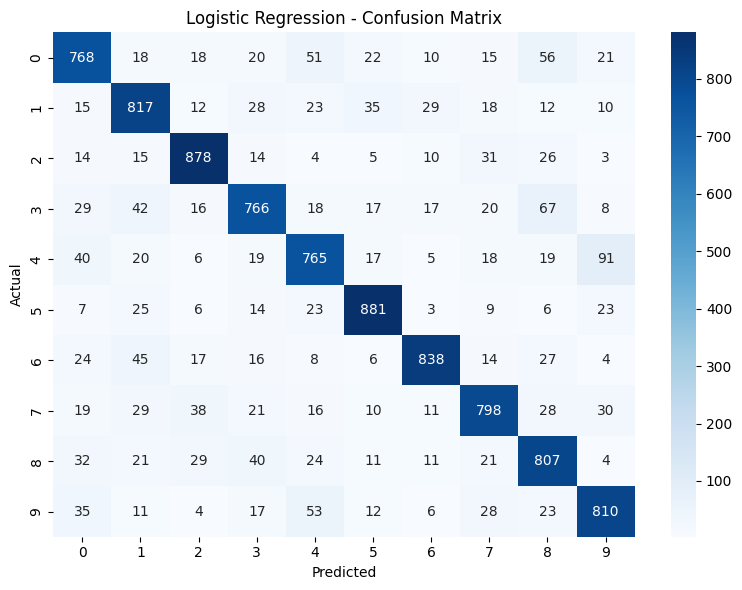


 Naive Bayes
Accuracy: 0.7968
ROC–AUC: 0.9734
              precision    recall  f1-score   support

           0       0.76      0.73      0.75       999
           1       0.80      0.77      0.79       999
           2       0.84      0.86      0.85      1000
           3       0.74      0.77      0.75      1000
           4       0.80      0.73      0.77      1000
           5       0.88      0.85      0.86       997
           6       0.89      0.81      0.85       999
           7       0.76      0.82      0.79      1000
           8       0.73      0.79      0.76      1000
           9       0.79      0.83      0.81       999

    accuracy                           0.80      9993
   macro avg       0.80      0.80      0.80      9993
weighted avg       0.80      0.80      0.80      9993



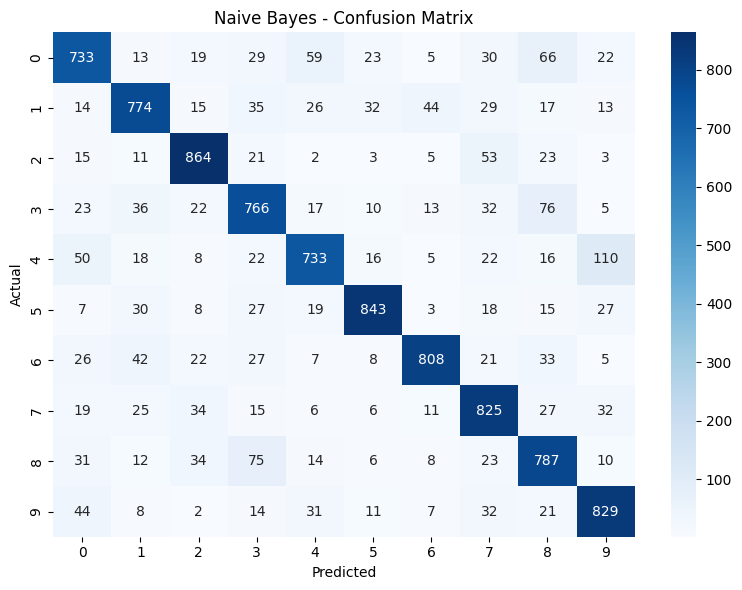


 SVM
Accuracy: 0.8153
ROC–AUC: 0.9707
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       999
           1       0.81      0.80      0.80       999
           2       0.86      0.88      0.87      1000
           3       0.78      0.76      0.77      1000
           4       0.78      0.75      0.76      1000
           5       0.87      0.92      0.90       997
           6       0.88      0.87      0.87       999
           7       0.81      0.79      0.80      1000
           8       0.76      0.77      0.77      1000
           9       0.81      0.81      0.81       999

    accuracy                           0.82      9993
   macro avg       0.81      0.82      0.81      9993
weighted avg       0.81      0.82      0.81      9993



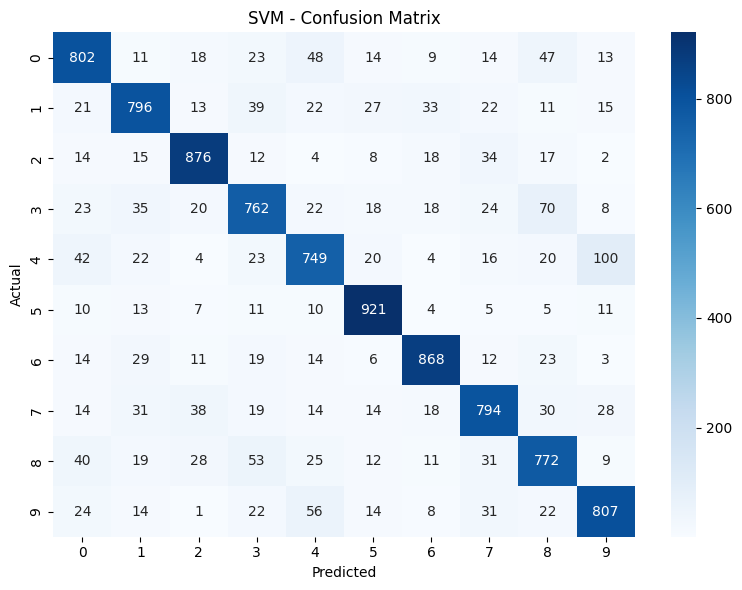


 Random Forest
Accuracy: 0.7411
ROC–AUC: 0.958
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       999
           1       0.63      0.70      0.66       999
           2       0.73      0.81      0.77      1000
           3       0.73      0.75      0.74      1000
           4       0.74      0.63      0.68      1000
           5       0.87      0.92      0.90       997
           6       0.80      0.80      0.80       999
           7       0.74      0.63      0.68      1000
           8       0.65      0.72      0.68      1000
           9       0.71      0.67      0.69       999

    accuracy                           0.74      9993
   macro avg       0.74      0.74      0.74      9993
weighted avg       0.74      0.74      0.74      9993



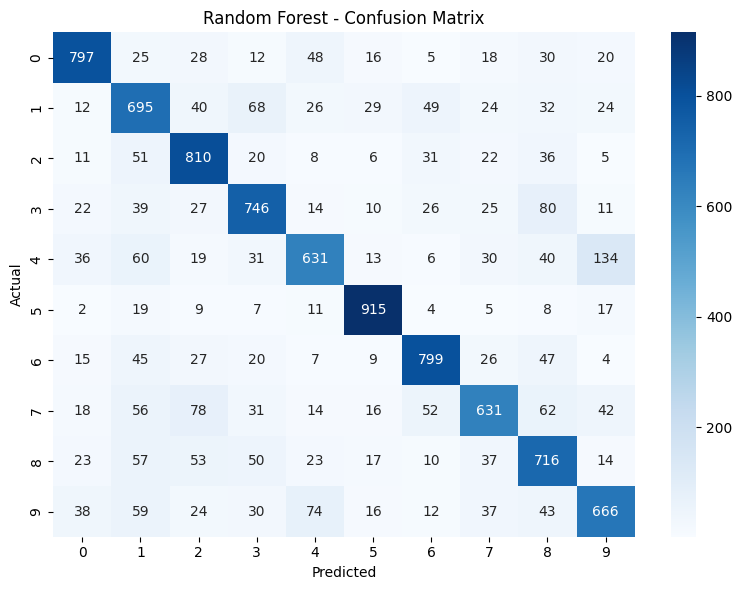

In [65]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver='lbfgs', n_jobs=-1),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []
classes = np.unique(y_train)  # get unique class labels

for name, model in models.items():

    model.fit(x_train_combined, y_train)
    y_pred = model.predict(x_test_combined)

    # --- Handle ROC–AUC safely ---
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_test_combined)
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(x_test_combined)

    if y_proba is not None:
        try:
            y_test_bin = label_binarize(y_test, classes=classes)
            roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')
        except Exception as e:
            roc_auc = np.nan
            print(f"ROC–AUC skipped for {name}: {e}")
    else:
        roc_auc = np.nan  # SVM (LinearSVC) doesn’t output probabilities

    acc = accuracy_score(y_test, y_pred)

    print(f"\n {name}")
    print("Accuracy:", round(acc, 4))
    print("ROC–AUC:", round(roc_auc, 4) if not np.isnan(roc_auc) else "N/A")
    print(classification_report(y_test, y_pred))

    results.append((name, acc, roc_auc))

    # --- Confusion Matrix ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
                cmap='Blues',xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f'{name} - Confusion Matrix')
    plt.tight_layout()
    plt.show()



In [32]:
# --- Summary Table ---
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "ROC–AUC"])
print("\n Model Performance Summary:")
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print(results_df)


 Model Performance Summary:
                 Model  Accuracy   ROC–AUC
2                  SVM  0.815271  0.970722
0  Logistic Regression  0.813369  0.974339
1          Naive Bayes  0.796758  0.973351
3        Random Forest  0.741119  0.958042


***7.2.1. Visualizing the distribution of traditional models accuracy***

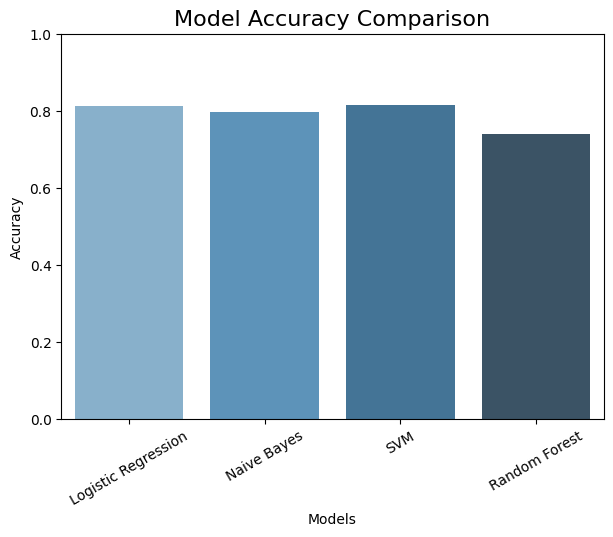

In [34]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "ROC–AUC"])
# Sort by Accuracy (optional)



# Plot
plt.figure(figsize=(7, 5))
sns.barplot(data=results_df, x="Model", y="Accuracy",hue="Model", palette="Blues_d", legend=False)
plt.title("Model Accuracy Comparison", fontsize=16)
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

**Key Insights**:

* **SVM**: Best accuracy and strong AUC indicate excellent overall performance and balanced class prediction.
* **Logistic Regression**: Slightly lower accuracy but highest AUC, meaning it distinguishes between classes very well — strong generalization.
* **Naive Bayes**: Performs well given its simplicity; effective for text data with word frequency features (e.g., TF–IDF).
* **Random Forest**: Lowest accuracy and AUC; may not capture text feature relationships as effectively as linear models.

**Conclusion**:

Both SVM and Logistic Regression demonstrated strong, consistent performance in classifying news articles. SVM stands out as the best model for deployment due to its slightly higher accuracy and robustness across all categories. The models’ ability to distinguish between multiple topics makes them suitable for real-world applications such as news recommendation engines, topic tagging, and automated editorial workflows.

***7.2. Model Optimization***

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [64]:
svc = LinearSVC(max_iter=5000)


param_grid = {
    'C': [0.1, 1, 10],               # Regularization parameter
    'loss': ['hinge', 'squared_hinge']
}

# GridSearchCV
grid_search = GridSearchCV(
    svc,
    param_grid,
    cv=3,                 # 3-fold CV for faster experiments
    scoring='accuracy',
    n_jobs=-1             # use all CPU cores
)

# Fit model
grid_search.fit(x_train_combined, y_train)

# Results
print("Best svc Parameters:", grid_search.best_params_)
print("Best svc Accuracy:", grid_search.best_score_)


Best svc Parameters: {'C': 0.1, 'loss': 'squared_hinge'}
Best svc Accuracy: 0.8092164515160611


### ***8. Model Deployment***

Deploying trained SVM model as its accuracy is great comparing to other models.

Joblib is used to save and load trained models efficiently, allowing reuse without retraining. It’s fast and handles large NumPy arrays, making it ideal for storing ML models.

In [37]:
import joblib
import pickle

SVC_model = models["SVM"]
SVC_model.fit(x_train_combined, y_train)
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(SVC_model, "SVC_model.pkl")


['SVC_model.pkl']

In [45]:

try:
    svc_model = joblib.load("SVC_model.pkl")
    tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")
except FileNotFoundError:
    print("Error: Model or vectorizer file not found. Ensure files are named 'svm_classifier.pkl' and 'tfidf_vectorizer_news.pkl'.")
    exit()

# Function to clean and preprocess text
def preprocess_text(text):
    # Standard cleaning for news articles
    text = str(text) # Ensure the input is a string
    text = text.lower().strip()
    # Keep letters, numbers, and basic symbols that might be important (like &)
    text = re.sub(r'[^a-z0-9\s&]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to extract textual features (4 features: word_count, char_count, avg_word_len, unique_word_ratio)
def extract_text_features_single(text):
    words = text.split()
    word_count = len(words)
    char_count = len(text)

    avg_word_length = np.mean([len(w) for w in words]) if word_count > 0 else 0

    if word_count > 0:
        unique_words = set(words)
        unique_word_ratio = len(unique_words) / word_count
    else:
        unique_word_ratio = 0

    return np.array([[word_count, char_count, avg_word_length, unique_word_ratio]])


# Function to predict category
def predict_category(headline, short_description, keywords=""):
    """
    Predicts the category of a new article based on its components.
    """

    # 1. Combine the features into a single input string
    new_text = f"{headline} {short_description} {keywords}"

    # 2. Preprocess the combined text
    cleaned_text = preprocess_text(new_text)

    # 3. TF-IDF transform
    tfidf_features = tfidf_vectorizer.transform([cleaned_text])

    # 4. Textual features
    text_features = extract_text_features_single(cleaned_text)

    # 5. Combine both
    combined_features = hstack([tfidf_features, text_features])

    # 6. Predict the class (the category label)
    # The output is the predicted category name (e.g., 'POLITICS', 'WELLNESS')
    prediction = svc_model.predict(combined_features)[0]

    # 7. Get the raw confidence score for multi-class classification
    # decision_function output shape is (1, n_classes). We take the max value.
    confidence_scores = svc_model.decision_function(combined_features)[0]

    # The confidence is usually the raw score for the predicted class
    predicted_index = np.where(svc_model.classes_ == prediction)[0][0]
    confidence = confidence_scores[predicted_index]
    confidence = float(1 / (1 + np.exp(-confidence)))

    return prediction, confidence



**Model performance on new unseen data**

***Travel article***

In [51]:
category, score = predict_category(
    headline="Top 10 Hidden Beaches to Visit in Southeast Asia This Summer",
    keywords="tourism, vacation, destinations, adventure, travel tips",
    short_description="From Thailand’s secret islands to Bali’s quiet coves, here’s your guide to the most beautiful yet underrated tropical escapes.")
category_text = le.inverse_transform([category])[0]
print(f"Predicted Category: {category_text}, Confidence_score: {score}")


Predicted Category: TRAVEL, Confidence_score: 0.9684832333961614


***Wellness category***

In [46]:
category, score = predict_category(
    headline="Morning Meditation Can Improve Focus and Reduce Stress, Study Finds",
    short_description="Lawmakers spent a week debating the complex fiscal plan.",
    keywords="New research highlights how daily mindfulness routines help lower cortisol levels and enhance concentration throughout the day.")
category_text = le.inverse_transform([category])[0]
print(f"Predicted Category: {category_text}, Confidence_score: {score}")

Predicted Category: WELLNESS, Confidence_score: 0.8386553769373306


***Business category***

In [52]:
category, score = predict_category(
    headline="Stock Markets Surge After Tech Companies Report Record Profits",
    short_description="Strong quarterly results from top technology firms pushed global indices higher, signaling renewed investor optimism.",
    keywords="finance, stock market, economy, startups, investment")
category_text = le.inverse_transform([category])[0]
print(f"Predicted Category: {category_text}, Confidence_score: {score}")

Predicted Category: BUSINESS, Confidence_score: 0.9081977086882581


***Sports category***

In [53]:
category, score = predict_category(
    headline="Team India Clinches Victory in Thrilling World Cup Final",
    short_description="An unforgettable final match ended with India securing the title, marking their third World Cup triumph in history.",
    keywords="cricket, football, sports news, tournament, championship")
category_text = le.inverse_transform([category])[0]
print(f"Predicted Category: {category_text}, Confidence_score: {score}")

Predicted Category: SPORTS, Confidence_score: 0.8747344864257689


**Conclusion**:

The **Linear SVC model** performs strongly in multi-class news classification, achieving high confidence scores across categories: Travel (0.97), Wellness (0.84), Business (0.91), and Sports (0.87). The combination of thorough **preprocessing**, **TF-IDF vectorization**, and **textual statistics feature engineering** enabled the model to effectively capture both semantic and structural patterns in the text. Overall, Linear SVC proves to be a **robust and reliable choice** for accurately classifying unseen news articles.

[Video Explanation](https://drive.google.com/file/d/1uvGPK1rDs8QWnqwu4FGp8OgzfAyGwmaC/view?usp=sharing)